In [37]:
from sklearn import datasets
import pandas as pd
import numpy as np
from numpy.linalg import inv
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [89]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [90]:
def color_funtion(clazz):
    if (clazz == 0):
        return 'red'
    elif(clazz == 1):
        return 'blue'
    else:
        return 'green'

### *LDA parameter estimation according to ISL chapter 4 slides page 26 *

In [134]:
zero_class_index = np.argwhere(y == 0).T
one_class_index = np.argwhere(y == 1).T
two_class_index = np.argwhere(y == 2).T

In [135]:
X_zero = np.squeeze(X[zero_class_index])
X_one = np.squeeze(X[one_class_index])
X_two = np.squeeze(X[two_class_index])

In [136]:
n_zero = zero_class_index.shape[1]
n_one = one_class_index.shape[1]
n_two = two_class_index.shape[1]
N = y.shape[0]

In [137]:
pi_zero = n_zero / N
pi_one = n_one / N 
pi_two = n_two / N 

In [138]:
mu_zero = np.sum(X_zero, axis=0, keepdims=True) / n_zero
mu_one = np.sum(X_one, axis=0, keepdims=True) / n_one
mu_two = np.sum(X_two, axis=0, keepdims=True) / n_two

In [139]:
sigma_zero = np.dot((X_zero - mu_zero).T, (X_zero - mu_zero))
sigma_one = np.dot((X_one - mu_one).T, (X_one - mu_one))
sigma_two = np.dot((X_two - mu_two).T, (X_two - mu_two))

In [140]:
sigma = (sigma_zero + sigma_one + sigma_two) / (N-3)

In [141]:
sigma

array([[0.265 , 0.0931, 0.1674, 0.0385],
       [0.0931, 0.1159, 0.0552, 0.0334],
       [0.1674, 0.0552, 0.1852, 0.0425],
       [0.0385, 0.0334, 0.0425, 0.042 ]])

In [142]:
sigma_inv = inv(sigma)

In [143]:
sigma_inv

array([[10.8712, -5.4473, -9.0099,  3.5017],
       [-5.4473, 14.3476,  2.7655, -9.2265],
       [-9.0099,  2.7655, 14.7684, -8.9038],
       [ 3.5017, -9.2265, -8.9038, 36.9532]])

In [144]:
def discriminator(sigma_inv, mu, pi, X):
    return np.dot(X,np.dot(sigma_inv,mu.T)) - 0.5*(np.dot(mu,np.dot(sigma_inv,mu.T))) + math.log(pi)

### *Seba-claudio method*

In [158]:
def plot_discriminator_reduction(mu1,pi1,mu2,pi2,sigma_inv):
    X_zero_discrimitator_zero = discriminator(sigma_inv, mu1, pi1, X_zero)
    X_one_discrimitator_zero = discriminator(sigma_inv, mu1, pi1, X_one)
    X_two_discrimitator_zero = discriminator(sigma_inv, mu1, pi1, X_two)
    X_zero_discrimitator_one = discriminator(sigma_inv, mu2, pi2, X_zero)
    X_one_discrimitator_one = discriminator(sigma_inv, mu2, pi2, X_one)
    X_two_discrimitator_one = discriminator(sigma_inv, mu2, pi2, X_two)

    discriminant_X1 = np.r_[X_zero_discrimitator_zero,X_one_discrimitator_zero,X_two_discrimitator_zero]
    discriminant_X2 = np.r_[X_zero_discrimitator_one,X_one_discrimitator_one,X_two_discrimitator_one]
    discriminant_X = np.c_[discriminant_X1,discriminant_X2]

    discriminant_X = pd.DataFrame(discriminant_X,columns=['x1','x2'])
    discriminant_X['color'] = y

    sns.lmplot("x1", "x2", data=discriminant_X, fit_reg=False, hue="color")
    plt.show()

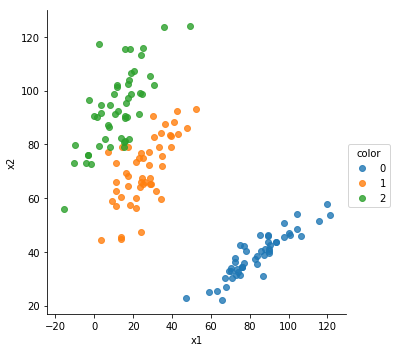

In [159]:
plot_discriminator_reduction(mu_zero, pi_zero, mu_one, pi_one, sigma_inv)

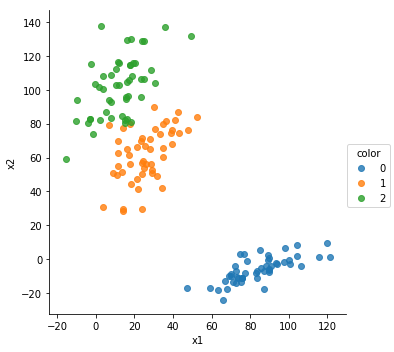

In [160]:
plot_discriminator_reduction(mu_zero, pi_zero, mu_two, pi_two, sigma_inv)

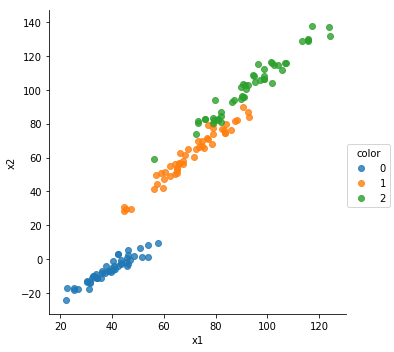

In [161]:
plot_discriminator_reduction(mu_one, pi_one, mu_two, pi_two, sigma_inv)

## *Dimension reduction usign sklearn LDA*

In [22]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [29]:
X_lda = lda.fit(X, y).transform(X)
lda_df = pd.DataFrame(X_lda, columns=['x1','x2'])
lda_df['color'] = y

<Figure size 2160x1080 with 0 Axes>

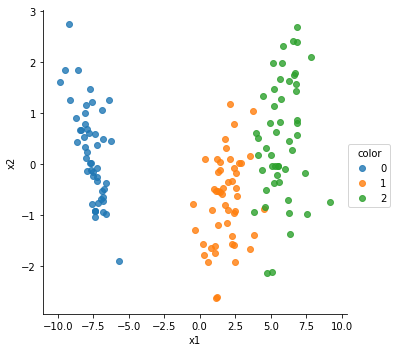

In [30]:
plt.figure(figsize=(30,15))
sns.lmplot("x1", "x2", data=lda_df, fit_reg=False, hue="color")
plt.show()

### *Como esta esta en libro elements of statistical learning*

In [49]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [58]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(0,3):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl]))

Mean Vector class 0: [5.006 3.418 1.464 0.244]

Mean Vector class 1: [5.936 2.77  4.26  1.326]

Mean Vector class 2: [6.588 2.974 5.552 2.026]



In [59]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(0,3), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [60]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


In [61]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.6104]
 [-0.3325]
 [-0.3415]
 [ 0.1585]]
Eigenvalue 3: 1.48e-15

Eigenvector 4: 
[[ 0.6104]
 [-0.3325]
 [-0.3415]
 [ 0.1585]]
Eigenvalue 4: 1.48e-15


In [62]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.27195779972982
0.27756686384004503
6.613543721484293e-15
6.613543721484293e-15


In [63]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [64]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.2049 -0.009 ]
 [-0.3871 -0.589 ]
 [ 0.5465  0.2543]
 [ 0.7138 -0.767 ]]


In [65]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

/Users/claudio.gauna/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 2160x1080 with 0 Axes>

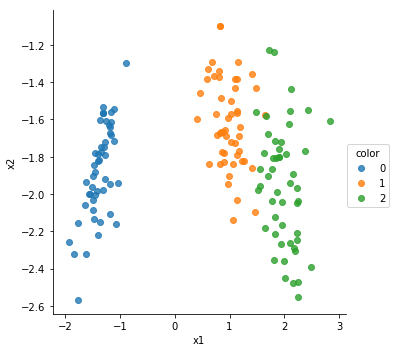

In [68]:
lda_df = pd.DataFrame(X_lda, columns=['x1','x2'])
lda_df['color'] = y
plt.figure(figsize=(30,15))
sns.lmplot("x1", "x2", data=lda_df, fit_reg=False, hue="color")
plt.show()